# Lab/HomeWork  01:  

### Comparison of background segmentation algorithms.

### Objective of the lab:

- You will use a standard evaluation proceedure that is often used in computer science conferences.
- This evaluation will test BackgroundSubtraction methods that are implemented in OpenCV.  
- The idea is to obtain intuition about the available methods:  situations in which the perform well and in others where they perform poorly.
- You will use the CDNet dataset that contains image sequences (videos) in a number of different situations.


### Submission Deadline:

- 1.5 week:  (26-march-2023)


## Exercise Problem:   Evaluating Background Subtraction With CDNet

1. Follow the steps below and use the script provided, [evaluation.py](https://github.com/opencv/opencv_contrib/blob/master/modules/bgsegm/samples/evaluation.py) to perform evaluations with several Background Subtraction techniques.  The script has been modified (see the accompanying notebook for following the evaluation) so that you can compare the different background subtraction algorithms we described above on the CDnet dataset.   From the results, make tables/figures using the different categories;  Explain and present your results according to the instructions below in "Submission of your work".

2. If you want to visually inspect the results, how could you output either the background images in the sequence, and/or form a video?  For example, you could save the images and then use the ffmpeg command from the first notebook of this class, namely: 

```
ffmpeg -framerate 25 -pattern_type glob -i './input/*.jpg' -c:v libx264 -pix_fmt yuv420p test.mp4
```

##  Submission of your work


You should submit a **jupyter notebook** of your results. The jupyter notebook should have the following sections: 
- **Introduction:**  A brief restatement of the problem to be solved.  
- **Methods:** A description of the methods thats you have selected to compare.  Include references to the methods. 
- **Results:** The results that you obtain by running the results.  This should include at the minimum (1) a talbe (or set of tables) with the comparitive results of method for the different situations in the CDNet, and (2) some images of results that may illustrate behavior of one algorithm over another. 
- **Discussion:** Given the results, what conclusions can you draw about the algorithms used.  For example, perhaps some algorithms worked best in certain situations with different parameters than others.  This section should be used to assess the overal understanding of the methods.  In which ways to the bgsegm  algorithms improve over the classical methods?
- **References:**  Provide relevant references to the resources and/or methods used. 


## Steps for performing the evaluations: 

1.  Download all the videos:  
- [cdnet_dataset2012](http://jacarini.dinf.usherbrooke.ca/static/dataset/dataset2012.zip)
- [cdnet dataset2014](http://jacarini.dinf.usherbrooke.ca/static/dataset/dataset2014.zip)

2. Alternatively, you could download selective files (however, the full statistics of the test will not be available).

An example of the file from the changenet data is the following

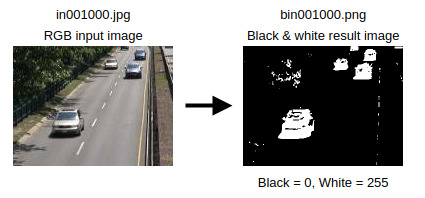

3. Put these image sequences in a directory that your notebook can access. (Note: ey are not inform of video, but are actually frames)


4. So that you can see the evaluation code, the entire script is given below. You will run this for the evaluation.  
- to run the code below, you would run the following in another cell: 

```
main_evaluator(['--dataset_path','xxxx', '--algorithm', 'yyyy'])
```

##  Data


The [CDNet](http://changedetection.net/)  dataset for 2012 contains is structured as follows: 

```
 ./dataset/
     ./baseline/
          ./highway/  
          ./office/
          ./pedestrians/
          ./PETS2006/
     ./cameraJitter/
     ./dynamicBackground/
     ./intermittentObjectMotion/
     ./shadow/
     ./thermal/
```

Only the baseline subdirectories are shown for illustrative purposes. 
Within each of these subdirectories, there are 2 directories: 
```
    ./input/
    ./groundtruth
```
These files, as the names indicate, will contain input image sequences and the ground-truth background 
substraction.  The evaluation code below will search recursively for the appropriate directories for the test.


Distributed with this notebook, are the  ``./dataset/baseline/highway/``  image sequences.  

Two images along the timeline are as follows: 


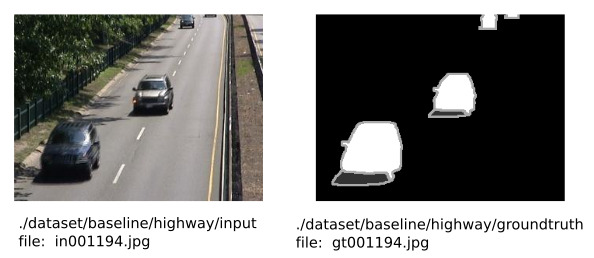

As shall be shown below,  the way to specify the directories for running the associated tests with the script below is simply specifying:  

``` 
./dataset/baseline/
```

All relevant subdirectories will be found recursively.

The full evaluation code is given below.  You can modif the list:
``ALGORITHMS_TO_EVALUATE``  to add other algorithms (such as the KNN).   Only the algorithms within the ``bgsegm`` have been written below.

In [21]:
import argparse
import cv2 as cv
import glob
import numpy as np
import os
import time

# This tool is intended for evaluation of different background subtraction algorithms presented in OpenCV.
# Several presets with different settings are available. You can see them below.
# This tool measures quality metrics as well as speed.

ALGORITHMS_TO_EVALUATE = [
    (cv.bgsegm.createBackgroundSubtractorMOG, 'MOG', {}),
    (cv.bgsegm.createBackgroundSubtractorGMG, 'GMG', {}),
    (cv.bgsegm.createBackgroundSubtractorCNT, 'CNT', {}),
    (cv.bgsegm.createBackgroundSubtractorLSBP, 'LSBP-vanilla', {'nSamples': 20, 'LSBPRadius': 4, 'Tlower': 2.0, 'Tupper': 200.0, 'Tinc': 1.0, 'Tdec': 0.05, 'Rscale': 5.0, 'Rincdec': 0.05, 'LSBPthreshold': 8}),
    (cv.bgsegm.createBackgroundSubtractorLSBP, 'LSBP-speed', {'nSamples': 10, 'LSBPRadius': 16, 'Tlower': 2.0, 'Tupper': 32.0, 'Tinc': 1.0, 'Tdec': 0.05, 'Rscale': 10.0, 'Rincdec': 0.005, 'LSBPthreshold': 8}),
    (cv.bgsegm.createBackgroundSubtractorLSBP, 'LSBP-quality', {'nSamples': 20, 'LSBPRadius': 16, 'Tlower': 2.0, 'Tupper': 32.0, 'Tinc': 1.0, 'Tdec': 0.05, 'Rscale': 10.0, 'Rincdec': 0.005, 'LSBPthreshold': 8}),
    (cv.bgsegm.createBackgroundSubtractorLSBP, 'LSBP-camera-motion-compensation', {'mc': 1}),
    (cv.bgsegm.createBackgroundSubtractorGSOC, 'GSOC', {}),
    (cv.bgsegm.createBackgroundSubtractorGSOC, 'GSOC-camera-motion-compensation', {'mc': 1})
]

def contains_relevant_files(root):
    return os.path.isdir(os.path.join(root, 'groundtruth')) and os.path.isdir(os.path.join(root, 'input'))


def find_relevant_dirs(root):
    relevant_dirs = []
    for d in sorted(os.listdir(root)):
        d = os.path.join(root, d)
        if os.path.isdir(d):
            if contains_relevant_files(d):
                relevant_dirs += [d]
            else:
                relevant_dirs += find_relevant_dirs(d)
    return relevant_dirs


def load_sequence(root):
    gt_dir, frames_dir = os.path.join(root, 'groundtruth'), os.path.join(root, 'input')
    gt = sorted(glob.glob(os.path.join(gt_dir, '*.png')))
    f = sorted(glob.glob(os.path.join(frames_dir, '*.jpg')))
    assert(len(gt) == len(f))
    return gt, f


def evaluate_algorithm(gt, frames, algo, algo_arguments):
    bgs = algo(**algo_arguments)
    mask = []
    t_start = time.time()

    for i in range(len(gt)):
        frame = np.uint8(cv.imread(frames[i], cv.IMREAD_COLOR))
        mask.append(bgs.apply(frame))

    average_duration = (time.time() - t_start) / len(gt)
    average_precision, average_recall, average_f1, average_accuracy = [], [], [], []

    for i in range(len(gt)):
        gt_mask = np.uint8(cv.imread(gt[i], cv.IMREAD_GRAYSCALE))
        roi = ((gt_mask == 255) | (gt_mask == 0))
        if roi.sum() > 0:
            gt_answer, answer = gt_mask[roi], mask[i][roi]

            tp = ((answer == 255) & (gt_answer == 255)).sum()
            tn = ((answer == 0) & (gt_answer == 0)).sum()
            fp = ((answer == 255) & (gt_answer == 0)).sum()
            fn = ((answer == 0) & (gt_answer == 255)).sum()

            if tp + fp > 0:
                average_precision.append(float(tp) / (tp + fp))
            if tp + fn > 0:
                average_recall.append(float(tp) / (tp + fn))
            if tp + fn + fp > 0:
                average_f1.append(2.0 * tp / (2.0 * tp + fn + fp))
            average_accuracy.append(float(tp + tn) / (tp + tn + fp + fn))

    return average_duration, np.mean(average_precision), np.mean(average_recall), np.mean(average_f1), np.mean(average_accuracy)


def evaluate_on_sequence(seq, summary):
    gt, frames = load_sequence(seq)
    category, video_name = os.path.basename(os.path.dirname(seq)), os.path.basename(seq)
    print('=== %s:%s ===' % (category, video_name))

    for algo, algo_name, algo_arguments in ALGORITHMS_TO_EVALUATE:
        print('Algorithm name: %s' % algo_name)
        sec_per_step, precision, recall, f1, accuracy = evaluate_algorithm(gt, frames, algo, algo_arguments)
        print('Average accuracy: %.3f' % accuracy)
        print('Average precision: %.3f' % precision)
        print('Average recall: %.3f' % recall)
        print('Average F1: %.3f' % f1)
        print('Average sec. per step: %.4f' % sec_per_step)
        print('')

        if category not in summary:
            summary[category] = {}
        if algo_name not in summary[category]:
            summary[category][algo_name] = []
        summary[category][algo_name].append((precision, recall, f1, accuracy))
        

def main_evaluator(args):
    
    global ALGORITHMS_TO_EVALUATE
    
    parser = argparse.ArgumentParser(description='Evaluate all background subtractors using Change Detection 2014 dataset')
    parser.add_argument('--dataset_path', help='Path to the directory with dataset. It may contain multiple inner directories. It will be scanned recursively.', required=True)
    parser.add_argument('--algorithm', help='Test particular algorithm instead of all.')

    args = parser.parse_args(args)
    print(f'Input file path: {args.dataset_path}')
    print(f'Number of times to repeat: {args.algorithm}')
    

    
    dataset_dirs = find_relevant_dirs(args.dataset_path)
    assert len(dataset_dirs) > 0, ("Passed directory must contain at least one sequence from the Change Detection dataset. There is no relevant directories in %s. Check that this directory is correct." % (args.dataset_path))
    
    
    if args.algorithm is not None:
        global ALGORITHMS_TO_EVALUATE
        ALGORITHMS_TO_EVALUATE = filter(lambda a: a[1].lower() == args.algorithm.lower(), ALGORITHMS_TO_EVALUATE)
    summary = {}

    output = None
    for seq in dataset_dirs:
        evaluate_on_sequence(seq, summary)

    for category in summary:
        for algo_name in summary[category]:
            summary[category][algo_name] = np.mean(summary[category][algo_name], axis=0)

    for category in summary:
        print('=== SUMMARY for %s (Precision, Recall, F1, Accuracy) ===' % category)
        for algo_name in summary[category]:
            print()
            output = ((algo_name,) + tuple(summary[category][algo_name]))
            print('%05s: %.3f %.3f %.3f %.3f' % output)
            
    return output
    



### Running the code in the notebook

In [22]:
## This is an example of how to run the above
#main_evaluator(['--dataset_path','xxxx', '--algorithm', 'yyyy'])

###  Example:

In the notebook directory, there is one of the datasets:  the baseline highway dataset. 
It is in the directory ./dataset/baseline/highway  relative to this notebook.  

Each video folder contains :
- a folder named 'input' containing a separate JPEG file for each frame of the input video
- a folder named 'groundtruth' containing a separate BMP file for each frame of the groundtruth


Note:  In the evaluation tests of the CDNet, they specify a ROI, however here, the tests use the entire image.

The following will run the highway example.  

In [23]:
outputs = []
outputs.append(main_evaluator(['--dataset_path','./dataset2012/dataset/thermal/', '--algorithm', 'MOG']))
outputs.append(main_evaluator(['--dataset_path','./dataset2012/dataset/thermal/', '--algorithm', 'CNT']))

Input file path: ./dataset2012/dataset/thermal/
Number of times to repeat: MOG
=== thermal:corridor ===
Algorithm name: MOG
Average accuracy: 0.983
Average precision: 0.840
Average recall: 0.244
Average F1: 0.292
Average sec. per step: 0.0030

=== thermal:diningRoom ===
=== thermal:lakeSide ===
=== thermal:library ===
=== thermal:park ===
=== SUMMARY for thermal (Precision, Recall, F1, Accuracy) ===

  MOG: 0.840 0.244 0.292 0.983
Input file path: ./dataset2012/dataset/thermal/
Number of times to repeat: CNT
=== thermal:corridor ===
=== thermal:diningRoom ===
=== thermal:lakeSide ===
=== thermal:library ===
=== thermal:park ===


In [24]:
print(outputs)

[('MOG', 0.8398597741573003, 0.24377409197978891, 0.2919082039026619, 0.9828644229990908), None]
